# 데이터 살펴보기

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

def gaussian_noise(x, scale=0.8):
    gaussian_data_x = x + np.random.normal(
        loc=0,
        scale=scale,
        size=x.shape
    )
    gaussian_data_x = np.clip(
        gaussian_data_x, 0, 1
    )
    gaussian_data_x = torch.tensor(gaussian_data_x)
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
    return gaussian_data_x

In [38]:
a = np.array([1, 2, 3, 4])
a = a + np.random.normal(
        loc=0,
        scale=0.5,
        size=a.shape
    )
np.clip(a, 0, 1)

array([0.85492483, 1.        , 1.        , 1.        ])

In [39]:
train_data = MNIST(
    root='/home/restful3/datasets/torch',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = MNIST(
    root='/home/restful3/datasets/torch',
    train=False,
    download=True,
    transform=ToTensor()
)

img = train_data.data[0]
gaussian = gaussian_noise(img)

/tmp/ipykernel_37258/375459002.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


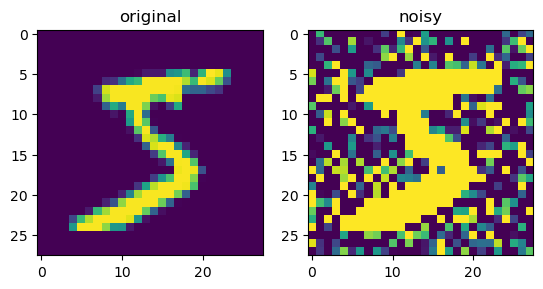

In [40]:
plt.subplot(1, 2, 1)
plt.title('original')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('noisy')
plt.imshow(gaussian)
plt.show()

# 학습용 데이터 만들기

In [41]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
    def __init__(self):
        self.mnist =  MNIST(
            root='/home/restful3/datasets/torch',
            train=True,
            download=True,
            transform=ToTensor()
        )
        self.data = []
        
        for i in range(len(self.mnist)):
            noisy_input = gaussian_noise(self.mnist.data[i]/255) # 이 부분을 책과 다르게 함 0 ~ 1 사이로 만듦
            input_tensor = torch.tensor(noisy_input)
            self.data.append(torch.unsqueeze(input_tensor, dim=0))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        data = self.data[i]
        label = self.mnist.data[i]/255
        return data, label

# 인코더 모델 정의하기

In [42]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels,
            hidden_dim,
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            hidden_dim,
            out_channels,
            kernel_size=3,
            padding=1
        )     
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        return x
    

In [43]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
        self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        return x

# 디코더 모델 정의하기

In [44]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim=8)
        self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)    
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.upsample1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)
        
        return x

# CAE 모델 정의하기

In [45]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        self.enc = Encoder()
        self.dec = Decoder()
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x)
        
        return x

# 모델 학습하기

In [47]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

trainset = Denoising()
train_loader = DataLoader(trainset, batch_size=32)

model = CAE().to(device)

lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
best_loss = float('inf')

for epoch in range(20):
    iterator = tqdm.tqdm(train_loader)
    
    for data, label in iterator:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        pred = model(data)
        
        loss = loss_fn(torch.squeeze(pred), label)
        loss.backward()
        optim.step()
        iterator.set_description(f"epoch : {epoch +1}, loss : {loss.item()}")
        # 현재 loss 값과 최소 loss 값을 비교하여 모델 저장
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), './models/CAE.pth')       

cuda


/tmp/ipykernel_37258/375459002.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
/tmp/ipykernel_37258/3039678083.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch : 1, loss : 0.0294429250061512: 100%|█| 1875/1875 [00:07<00:00, 240.83it/s
epoch : 2, loss : 0.028019165620207787: 100%|█| 1875/1875 [00:07<00:00, 236.68it
epoch : 3, loss : 0.027669940143823624: 100%|█| 1875/1875 [00:07<00:00, 250.11it
epoch : 4, loss : 0.027297617867588997: 100%|█| 1875/1875 [00:07<00:00, 251.60it
epoch : 5, loss : 0.026770321652293205: 100%|█| 1875/1875 [00:07<00:00, 249.58it
epoch : 6, loss : 0.0267510600388

# 모델 성능 평가하기

/tmp/ipykernel_37258/375459002.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


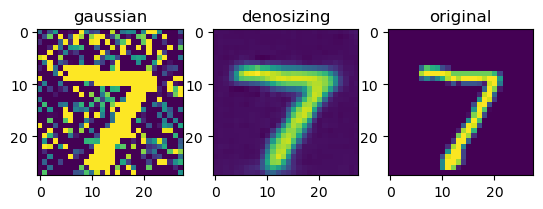

In [52]:
model.cpu() # matplotlib은 GPU 호환이 안되어, 출력을 cpu로 옮겨 줘야.

with torch.no_grad():
    model.load_state_dict(torch.load("./models/CAE.pth", map_location=device))
    
    img = test_data.data[0]
    gaussian = gaussian_noise(img)
    
    input_data = torch.unsqueeze(gaussian, dim=0)
    input_data.type(torch.FloatTensor)
    input_data.to(device)
    input_data = torch.unsqueeze(input_data, dim=0)
    
    plt.subplot(1, 3, 1)
    plt.imshow(torch.squeeze(gaussian))
    plt.title('gaussian')
    plt.subplot(1, 3, 2)
    plt.imshow(torch.squeeze(model(input_data)))
    plt.title('denosizing')    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.squeeze(img))    
    plt.title('original')        
    plt.show()